In [1]:
import pandas as pd
import os

# Read the CSV file into a pandas DataFrame
papers = pd.read_csv("datasets/papers.csv")

# Print head
papers.head()

,id,authors,year,title,pdf_name,abstract,paper_text
0,0004d0b59e19461ff126e3a08a814c33,"['Martijn Leisink', 'Bert Kappen']",2001,"Means, Correlations and Bounds",0004d0b59e19461ff126e3a08a814c33,The partition function for a Boltzmann ma...,Means. Correlations and Bounds \n\nM.A.R. ...
1,0004d0b59e19461ff126e3a08a814c33,['Seongmin Ok'],2020,A graph similarity for deep learning,0004d0b59e19461ff126e3a08a814c33,Graph neural networks (GNNs) have been success...,A Graph Similarity for Deep Learning\n\nSeongm...
2,000c076c390a4c357313fca29e390ece,"['Christoph Dann', 'Teodor Vanislavov Marinov'...",2021,Beyond Value-Function Gaps: Improved Instance-...,000c076c390a4c357313fca29e390ece,We provide improved gap-dependent regret bound...,Beyond Value-Function Gaps: Improved\nInstance...
3,003dd617c12d444ff9c80f717c3fa982,"['Ahmed Touati', 'Yann Ollivier']",2021,Learning One Representation to Optimize All Re...,003dd617c12d444ff9c80f717c3fa982,We introduce the forward-backward (FB) represe...,Learning One Representation to Optimize All\nR...
4,00411460f7c92d2124a67ea0f4cb5f85,"['Maxim Raginsky', 'Svetlana Lazebnik', 'Rebec...",2008,Near-minimax recursive density estimation on t...,00411460f7c92d2124a67ea0f4cb5f85,NaN,Near-Minimax Recursive Density Estimation\non ...


In [2]:
main_feature = "paper_text"
processed_feature = main_feature + '_processed'

In [3]:
# Remove the columns
papers = papers.drop(columns=['id', 'pdf_name'], axis=1)

# sample only 100 papers
papers = papers.sample(100)

# Print out the first rows of papers
papers.head()

,authors,year,title,abstract,paper_text
12514,"['Katja Schwarz', 'Yiyi Liao', 'Michael Niemey...",2020,GRAF: Generative Radiance Fields for 3D-Aware ...,While 2D generative adversarial networks have ...,GRAF: Generative Radiance Fields\nfor 3D-Aware...
11842,"['Maithra Raghu', 'Justin Gilmer', 'Jason Yosi...",2017,SVCCA: Singular Vector Canonical Correlation A...,"We propose a new technique, Singular Vector Ca...",SVCCA: Singular Vector Canonical Correlation\n...
1400,"['Jongjin Park', 'Younggyo Seo', 'Chang Liu', ...",2021,Object-Aware Regularization for Addressing Cau...,Behavioral cloning has proven to be effective ...,Object-Aware Regularization for\nAddressing Ca...
2995,"['Kolyan Ray', 'Botond Szabo']",2019,Debiased Bayesian inference for average treatm...,Bayesian approaches have become increasingly p...,Debiased Bayesian inference for average treatm...
466,"['Jianbo Yang', 'Xuejun Liao', 'Minhua Chen', ...",2014,Compressive Sensing of Signals from a GMM with...,This paper is concerned with compressive sensi...,Compressive Sensing of Signals from a GMM with...


In [4]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

12514    graf: generative radiance fields\nfor 3d-aware...
11842    svcca: singular vector canonical correlation\n...
1400     object-aware regularization for\naddressing ca...
2995     debiased bayesian inference for average treatm...
466      compressive sensing of signals from a gmm with...
Name: paper_text_processed, dtype: object

In [5]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['graf', 'generative', 'radiance', 'fields', 'for', 'aware', 'image', 'synthesis', 'katja', 'schwarz', 'yiyi', 'liao', 'michael', 'niemeyer', 'andreas', 'geiger', 'autonomous', 'vision', 'group', 'mpi', 'for', 'intelligent', 'systems', 'and', 'university', 'of', 'tubingen', 'tuempgde', 'abstract', 'while']


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [7]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /home/hari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
!python3.9 -m spacy download en_core_web_sm
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 95.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3.9 -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
['field', 'aware', 'image_synthesis', 'katja', 'liao', 'autonomous', 'vision', 'group', 'intelligent_system', 'university', 'tubingen', 'tuempgde', 'abstract', 'generative_adversarial', 'network', 'enable', 'high', 'resolution', 'image', 'syn', 'thesis', 'largely', 'lack', 'understand', 'world', 'image', 'formation', 'process', 'thus', 'provide']


In [10]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 6), (6, 4), (7, 1), (8, 2), (9, 1), (10, 5), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 3), (17, 2), (18, 3), (19, 1), (20, 1), (21, 1), (22, 8), (23, 1), (24, 2), (25, 4), (26, 2), (27, 4), (28, 1), (29, 1)]


In [11]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [12]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.289*"cid" + 0.008*"model" + 0.005*"function" + 0.005*"result" + '
  '0.005*"solution" + 0.005*"show" + 0.004*"input" + 0.004*"use" + '
  '0.004*"neural" + 0.004*"problem"'),
 (1,
  '0.020*"cid" + 0.014*"model" + 0.009*"learn" + 0.008*"time" + 0.008*"set" + '
  '0.006*"use" + 0.006*"datum" + 0.006*"method" + 0.006*"problem" + '
  '0.006*"function"'),
 (2,
  '0.009*"network" + 0.009*"neural" + 0.009*"learn" + 0.008*"method" + '
  '0.007*"use" + 0.007*"representation" + 0.006*"image" + 0.006*"model" + '
  '0.006*"show" + 0.005*"problem"'),
 (3,
  '0.017*"cid" + 0.015*"measure" + 0.011*"paper" + 0.009*"network" + '
  '0.009*"problem" + 0.008*"reviewer" + 0.008*"learn" + 0.007*"function" + '
  '0.007*"state" + 0.006*"set"'),
 (4,
  '0.017*"model" + 0.013*"learn" + 0.008*"network" + 0.008*"method" + '
  '0.008*"task" + 0.007*"cid" + 0.007*"use" + 0.006*"image" + 0.006*"set" + '
  '0.006*"learning"'),
 (5,
  '0.011*"model" + 0.009*"cid" + 0.008*"method" + 0.008*"path" + 0.007*"base"

In [13]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.277046287548003


In [25]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b, 
                                           workers = 20)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v', processes = 20)
    
    return coherence_model_lda.get_coherence()

In [26]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_1.csv', index=False)
    pbar.close()


  1%|          | 4/540 [00:53<1:59:37, 13.39s/it]

100%|██████████| 540/540 [1:20:57<00:00,  9.00s/it]


Final model

In [27]:
num_topics = 8

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

In [28]:
!pip install pyLDAvis

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.6 MB/s eta 0:00:0000:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 124.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.7/380.7 kB 103.4 MB/s eta 0:00:00
Using legacy 'setup.py install' for future, since package 'wheel' is not installed.
Using legacy 'setup.py install' for sklearn, since package 'wheel' is not installed.
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136882 sha256=4eb23caabd479854ab3ff9d97c7291096c57bb7e8998eef46ef2892b21ce82f0
  Stored in directory: /home/hari/.cache/pip/wheels/57/a4/86/d10c6c2e0bf149fbc0afb0a

In [30]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

# LDAvis_data_filepath = os.path.join('./results/ldavis_tuned_'+str(num_topics))
LDAvis_data_filepath = os.path.join('ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, 'ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

/home/hari/.local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.103794  0.054286       1        1  34.284386
1      0.093030  0.005705       2        1  25.147133
0      0.096902 -0.101617       3        1  18.333576
7      0.037473  0.046797       4        1  13.648993
6     -0.058366  0.034301       5        1   3.308361
3     -0.057391 -0.011234       6        1   3.026001
2     -0.076570 -0.010209       7        1   2.251070
5     -0.138872 -0.018028       8        1   0.000480, topic_info=         Term         Freq        Total Category  logprob  loglift
114       cid  9142.000000  9142.000000  Default  30.0000  30.0000
519   measure   382.000000   382.000000  Default  29.0000  29.0000
1409    agent   299.000000   299.000000  Default  28.0000  28.0000
595     paper   289.000000   289.000000  Default  27.0000  27.0000
412     image   548.000000   548.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
195     datum     0.000138   613.921778   Topic8  -8.8852  -3.0585
912     value     0.000137   540.088957   Topic8  -8.8988  -2.9440
37       also     0.000136   530.405246   Topic8  -8.9016  -2.9287
1713   policy     0.000135   517.415333   Topic8  -8.9086  -2.9108
944      work     0.000132   408.652786   Topic8  -8.9336  -2.6999

[576 rows x 6 columns], token_table=       Topic      Freq Term
term                       
4897       1  0.163239    _
4897       2  0.380892    _
4897       3  0.054413    _
4897       4  0.054413    _
4897       7  0.380892    _
...      ...       ...  ...
12018      1  0.245398  𝑀𝐸𝑓
12018      2  0.245398  𝑀𝐸𝑓
12018      3  0.245398  𝑀𝐸𝑓
12018      4  0.245398  𝑀𝐸𝑓
12018      7  0.245398  𝑀𝐸𝑓

[2249 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 8, 7, 4, 3, 6])

In [25]:
import pandas as pd

df = pd.read_csv('lda_tuning_results.csv')
print(df.head())
print(df[df['Coherence'] == max(df['Coherence'] )])

  Validation_Set  Topics Alpha                Beta  Coherence
0     75% Corpus       2  0.01                0.01   0.255210
1     75% Corpus       2  0.01                0.31   0.257202
2     75% Corpus       2  0.01                0.61   0.251002
3     75% Corpus       2  0.01  0.9099999999999999   0.250497
4     75% Corpus       2  0.01           symmetric   0.251002
    Validation_Set  Topics       Alpha                Beta  Coherence
268     75% Corpus      10  asymmetric  0.9099999999999999   0.425221


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
def int_to_round_str(val):
    
    try : 
        return str(np.round(float(val),4))
#         return str(val)[0]
    except :
        return str(val)
#         return str(val[0])
 

In [32]:
topic_10 = df[(df['Topics']==10 )& (df['Validation_Set']=='75% Corpus')]
topic_10.loc[:,'Alpha'] = topic_10.loc[:,'Alpha'] .map(lambda x: str(x))
topic_10.loc[:,'Beta'] =topic_10.loc[:,'Beta'] .apply(lambda x: int_to_round_str(x))

/var/folders/qj/0ym5ps652l76x64w3xg4ktw00000gn/T/ipykernel_14847/454671947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_10.loc[:,'Alpha'] = topic_10.loc[:,'Alpha'] .map(lambda x: str(x))
/var/folders/qj/0ym5ps652l76x64w3xg4ktw00000gn/T/ipykernel_14847/454671947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_10.loc[:,'Beta'] =topic_10.loc[:,'Beta'] .apply(lambda x: int_to_round_str(x))


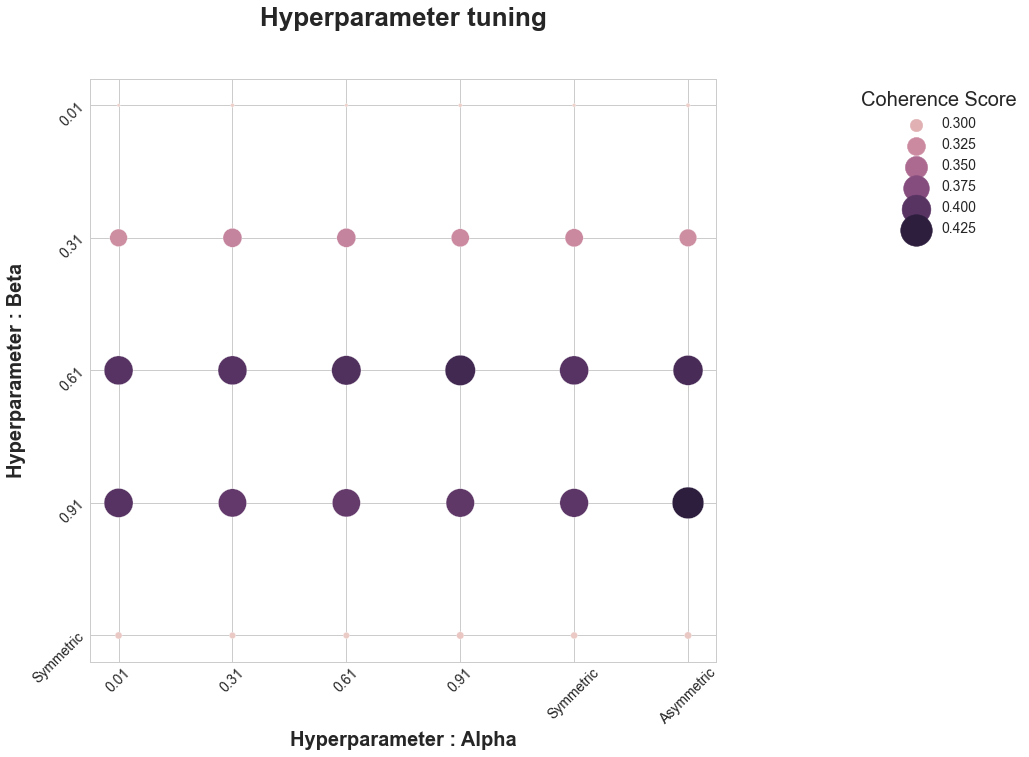

In [79]:
fig = plt.figure(figsize = (10, 10))
ax = plt.subplot(111)

plt.style.use('seaborn-whitegrid')
# sns.scatterplot(data = topic_10, x= 'Alpha', y = 'Coherence', hue = 'Beta', ax = ax)
sns.scatterplot(data = topic_10, x= 'Alpha', y = 'Beta', size = 'Coherence', hue = 'Coherence', sizes = (10, 1000), ax = ax)
    # plt.ylim(0, 1)
locs, labels = plt.xticks()
plt.xticks(locs, ['0.01', '0.31', '0.61', '0.91', 'Symmetric', 'Asymmetric'], rotation = 45)
locs, labels = plt.yticks()
plt.yticks(locs, ['0.01', '0.31', '0.61', '0.91', 'Symmetric'], rotation = 45)
# plt.legend(['0.01', '0.31', '0.61', '0.91', 'Symmetric', 'Asymmetric'], bbox_to_anchor=(1.5, 1))
plt.legend(bbox_to_anchor=(1.5, 1), title = 'Coherence Score', title_fontsize = 20)

plt.xlabel('Hyperparameter : Alpha', fontweight = 'bold', fontsize = 20)
plt.ylabel('Hyperparameter : Beta', fontweight = 'bold', fontsize = 20)
plt.title('Hyperparameter tuning', fontweight = 'bold', y=1.08, fontsize = 26)
plt.show()



ValueError: could not convert string to float: 'symmetric'